## For a given lake, grab all MERRA2 fields for the bounding box +/- 5 degrees 

To help us composite gridded quantities by distance from the CWV=55mm boundary contour, with a `groupby().mean()` operation, we need to construct a new distance field on the MERRA2 grid.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geopandas as gp

## Read all lakes in 2014-2018 
#### lakes dataframe was "improved" in LakeCaseStudy.ipynb with firsttime added

In [2]:
df = pd.read_csv('ccvls_stats_2014-2018.improved.csv')
# df

In [215]:
equatorcases = df[ abs(df.coastlat) < 10 ] # 162 of them exceeding 1 day 
eq7cases = equatorcases[ equatorcases.dur_days > 6 ]  # 39 of them exceeding a week (more than 6 in days) 
eq7cases.maxarea.size

39

In [216]:
# Pick one
case = eq7cases.iloc[5]

In [4]:
filename = case.filename
gdf = gp.read_file('GEOJSONS/'+filename)
gdf.set_crs(epsg = "4326", inplace = True)

# to avoid area warnings, use an equal-area map projection (CRS) - oh it doesnt matter near the equator on coarse grids
# https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
#.to_crs('+proj=cea')

,tqv_values,area,maxlon,time,tag,geometry
0,55,3.127315430115578,41.3606914397209,2017-05-28T11:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.01948, 40.00000 -6.05890..."
1,55,3.705780883103892,41.50255306746608,2017-05-28T10:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.20799, 40.00000 -6.10609..."
2,55,4.421360536963331,41.61843544195506,2017-05-28T09:00:00,2017_05_28_11_lat5p291S,"POLYGON ((41.25000 -6.51209, 41.30522 -6.50000..."
3,55,5.712516756510541,41.63930996981534,2017-05-28T08:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.56799, 39.46122 -6.50000..."
4,55,5.879193136034145,41.57302700743384,2017-05-28T07:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.56993, 39.46502 -6.50000..."
...,...,...,...,...,...,...
239,55,46.22785252433045,73.25500194842998,2017-05-21T11:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.54500, 67.74338 -10.500..."
240,55,46.35266701716529,73.37037750351976,2017-05-21T10:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.56662, 68.01992 -10.500..."
241,55,46.18782577541302,73.49186939558959,2017-05-21T09:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.55310, 68.12500 -10.543..."
242,55,46.86117232827137,73.61741666440611,2017-05-21T08:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.51405, 68.12500 -10.562..."


<AxesSubplot:>

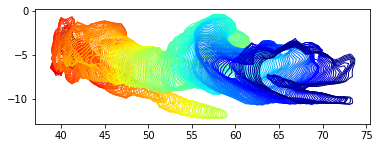

In [5]:
gdf.plot(column='time', facecolor='none', cmap='jet') #, alpha=1) #, legend=True)

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_43368/796279730.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.to_crs(gdf.crs).plot(ax=ax,color='black')
/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'polygons w/no holes? lasting 7 days, one merger')

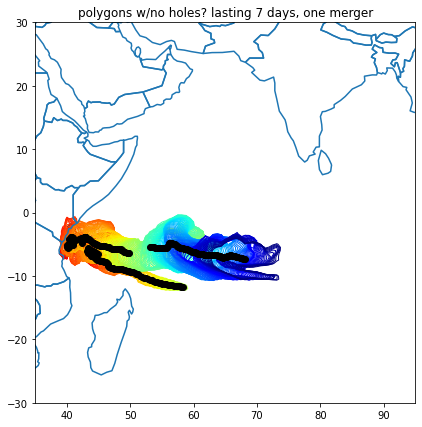

In [6]:
# with map context and centroids 
fig, ax = plt.subplots(figsize=[8,7])
ax.set_aspect('equal')
ax.set_xlim(35, 95)
ax.set_ylim(-30,30)

gdf.plot(ax=ax, column='time', facecolor='none', \
                cmap='jet', alpha=1) #, legend=True)

# OverPlot centroids 
gdf.centroid.to_crs(gdf.crs).plot(ax=ax,color='black')

#gdf.boundary.plot(ax=ax, color='black')
path = gp.datasets.get_path('naturalearth_lowres') # Geography background
mapdf = gp.read_file(path)
mapdf.boundary.plot(ax=ax)
    
ax.set_title('polygons w/no holes? lasting 7 days, one merger')

In [7]:
bounds = gdf.bounds
bounds.minx.min(), bounds.maxx.max(), bounds.miny.min(), bounds.maxy.max(),

(38.781707544120955, 73.71221550687433, -12.27921665736607, -0.398629940257389)

# Open MERRA2 files and combine all the wanted fields 
### (2D hourly collections on goldsmr4) 

In [478]:
d2diag = xr.open_dataset('https://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2T1NXINT')
d2flux = xr.open_dataset('https://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2T1NXFLX')
d2slv = xr.open_dataset('https://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2T1NXSLV')

var_diag = ['dqvdt_phy','dqvdt_dyn','dqvdt_ana','uflxqv','vflxqv','swnettoa']
var_flux = ['eflux','evap','hflux','preccon','precanv','prectot','prevtot','prectotcorr']
var_slv = [ 't2m','ts','t850','t500','q850','q500','slp','tqv','tqi','tql',  \
           'disph','tropt' ] # dummy ones to re-use as distance and direction

d2super = d2diag[ var_diag ].merge(d2flux[ var_flux ]).merge(d2slv[ var_slv ])\
        .rename({"disph":"distance"}).rename({"tropt":"dir_to_centroid"})

In [479]:
d2super

<xarray.Dataset>
Dimensions:          (time: 376944, lat: 361, lon: 576)
Coordinates:
  * time             (time) datetime64[ns] 1980-01-01T00:30:00.000003 ... 202...
  * lat              (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon              (lon) float64 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
Data variables: (12/26)
    dqvdt_phy        (time, lat, lon) float32 ...
    dqvdt_dyn        (time, lat, lon) float32 ...
    dqvdt_ana        (time, lat, lon) float32 ...
    uflxqv           (time, lat, lon) float32 ...
    vflxqv           (time, lat, lon) float32 ...
    swnettoa         (time, lat, lon) float32 ...
    ...               ...
    slp              (time, lat, lon) float32 ...
    tqv              (time, lat, lon) float32 ...
    tqi              (time, lat, lon) float32 ...
    tql              (time, lat, lon) float32 ...
    distance         (time, lat, lon) float32 ...
    dir_to_centroid  (time, lat, lon) float32 ...
Attributes:
    title:        MERRA-2 tavg1_2d_int_Nx: 2d,1-Hourly,Time-Averaged,Single-L...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Mon Jan 30 17:21:04 GMT 2023 : imported by GrADS Data Serve...

## Select M2 grid area sized to this entire Lake event +/- 5 degrees lat/lon 

In [372]:
d2 = d2super.sel( lat =slice(bounds.miny.min()-5, bounds.maxy.max()+5),
                  lon =slice(bounds.minx.min()-5, bounds.maxx.max()+5), 
                  time=slice(gdf.time.min(),gdf.time.max())             )

In [480]:
# Put a dummy distance field, initially large so min operator will replace it later 

d2.distance.values = d2.distance.values*0 +999.
d2['distance'].attrs['long_name'] = 'distance outside nearest lake (negative for interiors)'
d2['distance'].attrs['units'] = 'degrees lat/lon'
d2['dir_from_centroid'].attrs['long_name'] = 'navigation angle from centroid of nearest lake'
d2['dir_from_centroid'].attrs['units'] = 'nav.degrees'

# Distance and direction, for groupby composites 
### Make a Geoseries of all d2 dataset grid point lat,lon coordinates 

In [482]:
from shapely.geometry import Point
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

# Make an array of Points that are the gridpoints or MERRA2
lat2d = d2.lat.values[:,None]   + d2.lon.values*0
lon2d = d2.lat.values[:,None]*0 + d2.lon.values
points = gp.GeoSeries( [Point(x, y) for x, y in zip(lon2d.ravel(),lat2d.ravel()) ] )\
            .set_crs(epsg = "4326", inplace = True)

### tests: making the nav bearing (angle) field from the centroid

https://stackoverflow.com/questions/54873868/python-calculate-bearing-between-two-lat-long

62.0815687415608 -6.73298920385834


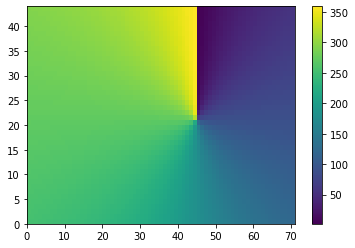

In [483]:
# test for one point, 205th polygon
import pyproj
geodesic = pyproj.Geod(ellps='WGS84')

centlon = gdf.geometry[205].centroid.x
centlat = gdf.geometry[205].centroid.y
print(centlon, centlat)

dir_to = []
for i in range(len(lon2d.ravel())): 
    fwd_az,back_az,d = geodesic.inv(lon2d.ravel()[i], lat2d.ravel()[i], [centlon], [centlat])
    dir_to.append(fwd_az+180)

dir_to = np.array(dir_to).reshape(len(d2.lat),len(d2.lon))
plt.pcolormesh( dir_to ); plt.colorbar()

## Loop over all the Lake geometries (polygons),
# *haven't tested multipolygon with holes in it yet!*,
### updating the minimum distance field and direction field, 
#### at the nearest hour and the hour before since they are half-hour offset 

In [383]:
import warnings
warnings.filterwarnings('ignore')

In [484]:
#    i=205    #for testing --> idx=38, a lovely heart shape
for i in range(gdf.time.size):     # the number of rows in the geoseries (polygons)

# Compute distance and direction fields:
# DIST: must compute distance to polygon BOUNDARY to get nonzero values inside it 
    dist = points.distance(gdf.geometry[i].boundary).values.reshape(len(d2.lat),len(d2.lon))
    isin = points.within(gdf.geometry[i]).values.reshape(len(d2.lat),len(d2.lon))
    dist *= (-2)*(isin-0.5)  # make SIGNED distance from boundary, positive is exterior 

# DIR: use geodesic method imported above. 
# Direction to centroid of WHOLE LAKE (multi-polygon in general) at this time
    agg_lake_at_time = gdf.geometry[ np.where(gdf.time == gdf.time[100])[0] ].unary_union
    centlon = agg_lake_at_time.centroid.x
    centlat = agg_lake_at_time.centroid.y
    
    #Careful, use j not i in stupid explicit loop, since geodesic takes scalar only 
    dir_to = []
    for j in range(len(lon2d.ravel())): 
        fwd_az,back_az,d = geodesic.inv(lon2d.ravel()[j], lat2d.ravel()[j], [centlon], [centlat])
        dir_to.append(fwd_az+180)
    dir_to = np.array(dir_to).reshape(len(d2.lat),len(d2.lon))
    
# if dist is less than previous distance in the dataset, replace that previous
    oldd = d2.sel(time = gdf.time[i],method='nearest').distance
    mindist = np.minimum(dist,oldd)
    # closer = np.where(dist < oldd) # a spatial index of where, couldn't make it work
    
# Here's a tricky thing, assigning values to the dataset - need to use index instead of sel
# sel cannot be used for assignment of values, only extraction of them. 
# idx of the time in d2 corresponding to this geometry object in the gdf
    idx = d2.indexes["time"].get_indexer([gdf.time[i]],method='nearest')[0]

# Assign the new mindist field at this time, & dir where (dist < oldd) for this object
    d2["distance"][idx] = mindist
    
# Assigning direction is even trickier. I can't seem to use "closer" 
# to reassign direction only in places where dist < oldd, such that 
# the direction field would be from the centroid of the CLOSEST polgon. 
# Instead, let's just assign direction from the centroid of the whole 
# unary union of all the individual polygons 

    d2["dir_from_centroid"][idx] = dir_to

#  these 1-hour averages are 30 minutes offset from tqv, argh. 
# just manually spray the mindist values to the next earlier time level too 
    try: 
        d2["distance"][idx-1] = mindist
        d2["dir_from_centroid"][idx-1] = dir_to

    except: 
        print('end of loop issue (first time in time-backward sequence over geometries)')


In [491]:
agg_lake_at_time = gdf.geometry[ np.where(gdf.time == gdf.time[102])[0] ].unary_union
centlon = agg_lake_at_time.centroid.x
centlat = agg_lake_at_time.centroid.y
print(centlon,centlat)

47.26874727369396 -6.162901137421338


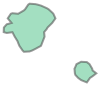

In [493]:
gdf.geometry[ np.where(gdf.time == gdf.time[102])[0] ].unary_union

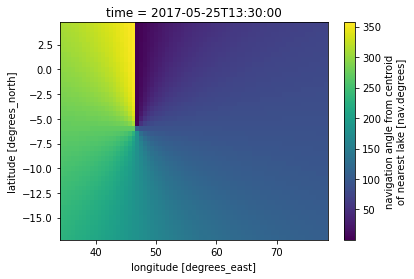

In [488]:
d2['dir_from_centroid'][102].plot() # 100 is a time with multiple fragments 

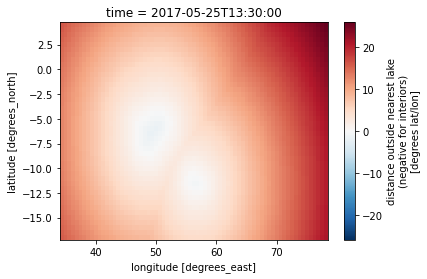

In [489]:
d2['distance'][102].plot() # 100 is a time with multiple fragments 

In [494]:
!date

Tue Jan 31 15:24:00 EST 2023


In [496]:
d2.to_netcdf('../../Library/CloudStorage/Box-Box/VaporLakes/data/LAKEBYLAKE/'+\
             filename[0:-8]+'.M2_all2Dfields.nc')

In [497]:
!date

Tue Jan 31 15:27:24 EST 2023


In [498]:
# read back off disk for faster computation
ddd = xr.open_dataset('../../Library/CloudStorage/Box-Box/VaporLakes/data/LAKEBYLAKE/'+filename[0:-8]+'.M2_my2Dfields.nc')

# Composites: groupby distance, 
### and by direction-from-centroid for propagation analysis 

https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html?highlight=groupby#Multidimensional-Groupby

In [237]:
composite = ddd.groupby('distance').mean()

In [273]:
composite

<xarray.Dataset>
Dimensions:      (distance: 234199)
Coordinates:
  * distance     (distance) float64 -2.874 -2.866 -2.857 ... 38.39 38.48 38.65
Data variables: (12/24)
    dqvdt_phy    (distance) float32 -1.522e-05 -2.316e-05 ... 0.0001106
    dqvdt_dyn    (distance) float32 0.0001534 0.0001366 ... -0.0002886
    dqvdt_ana    (distance) float32 -5.305e-05 -2.916e-05 ... 2.707e-05
    uflxqv       (distance) float32 -554.9 -589.2 -484.8 ... -334.5 -329.3
    vflxqv       (distance) float32 151.7 125.7 193.9 ... 92.76 81.59 71.82
    swnettoa     (distance) float32 17.23 0.0 591.3 247.7 ... 172.8 523.3 509.7
    ...           ...
    q850         (distance) float32 0.01342 0.01374 ... 0.009541 0.009587
    q500         (distance) float32 0.003582 0.003626 ... 0.0001699 0.0002028
    slp          (distance) float32 1.01e+05 1.01e+05 ... 1.018e+05 1.018e+05
    tqv          (distance) float32 61.7 62.17 60.88 61.22 ... 27.35 27.86 26.87
    tqi          (distance) float32 0.002624 0.00149 ... 9.236e-05 5.549e-05
    tql          (distance) float32 0.3027 0.3108 0.2903 ... 0.09525 0.07275

In [297]:
composite.to_netcdf('../../Library/CloudStorage/Box-Box/VaporLakes/data/LAKEBYLAKE/'+filename[0:-8]+'.M2_composite.nc')

Text(0.5, 0.98, '2017_05_28_11_lat5p291S.geojsonMERRA2 composite 244 objects')

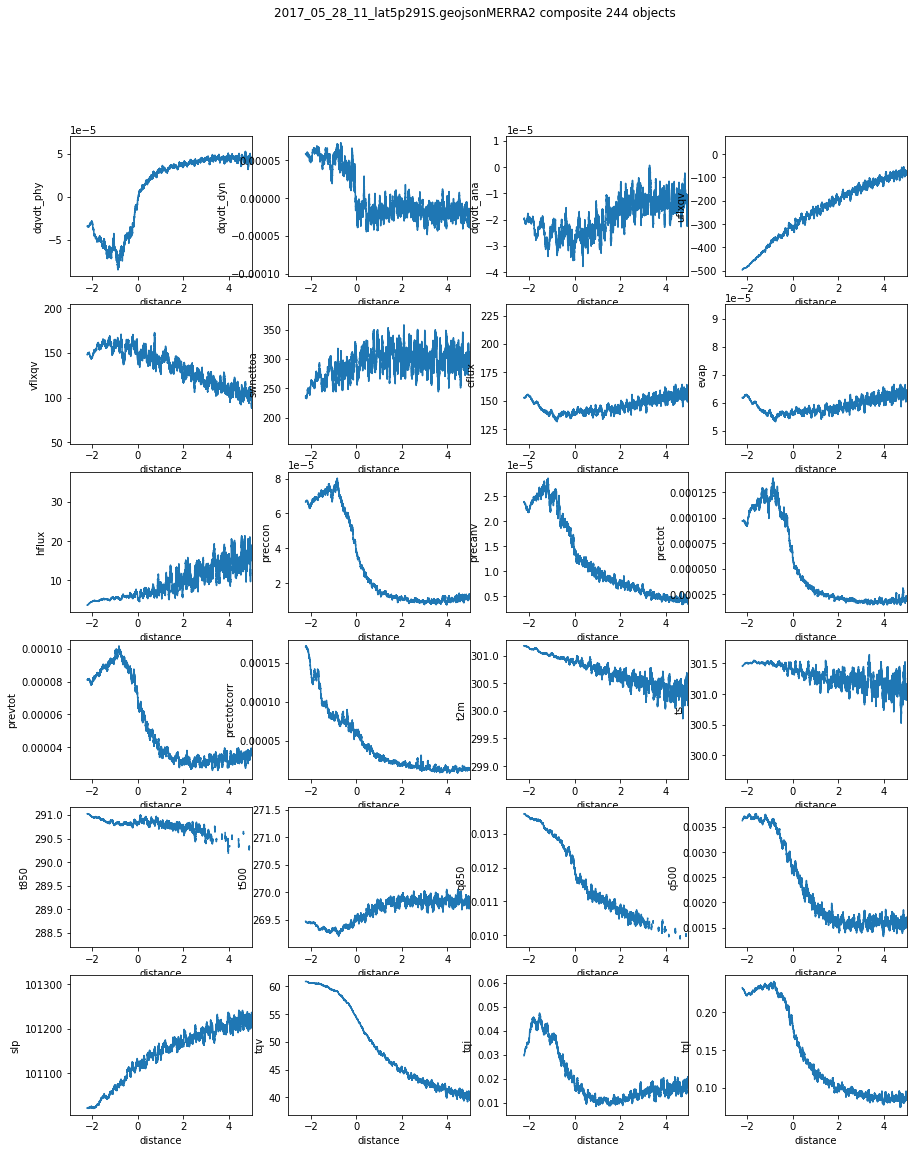

In [296]:
# That was slow! So many bins of distance, next time specify them. 
# rolling mean = Smoothing 

# Plot them all 
vars = list(composite.keys())
# len(vars) #24

fig, ax = plt.subplots(6,4, figsize=(15,18))

#composite..rolling(distance=200, center=True).mean().plot(xlim=[-3,5], ax=ax.ravel()[0])
#plt.title('Composite by distance MERRA2 for '+filename)

for i in range(len(vars)):
    composite[vars[i]].rolling(distance=400, center=True).mean().plot(xlim=[-3,5], ax=ax.ravel()[i] )

plt.suptitle(filename + 'MERRA2 composite '+str(len(gdf))+' objects')
